DATA IMPORT,PREPROCEEING AND VISUALIZATION(DATA PREPARATION)

In [8]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


In [9]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,116.860001,115.809998,115.919998,116.610001,22193600.0,111.727715
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,112.973305
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,114.008080
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,114.123047
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,114.736275


Let's take a look at how the prices looks like each day since the beginning up to this point with the date on the x-axis and the price on the y-axis.

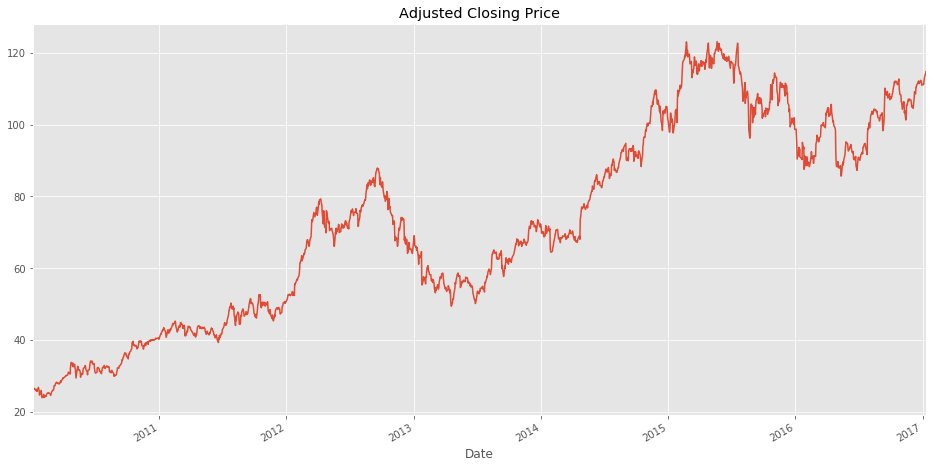

In [10]:
df['Adj Close'].plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

 We will thus create a 2D matrix of training samples with each row being the prices 32 consecutive days in the past with the price to predict being the current day.

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

**USING SCIKIT LEARN MODELS FOR TRAINING AND INFERENCE ON THE TRAIN AND TEST DATA.**

METHOD 1 *RIDGE REGRESSION*



In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

PLOT OF THE TRAINING DATA AGAINTS THE ACTUAL DATA

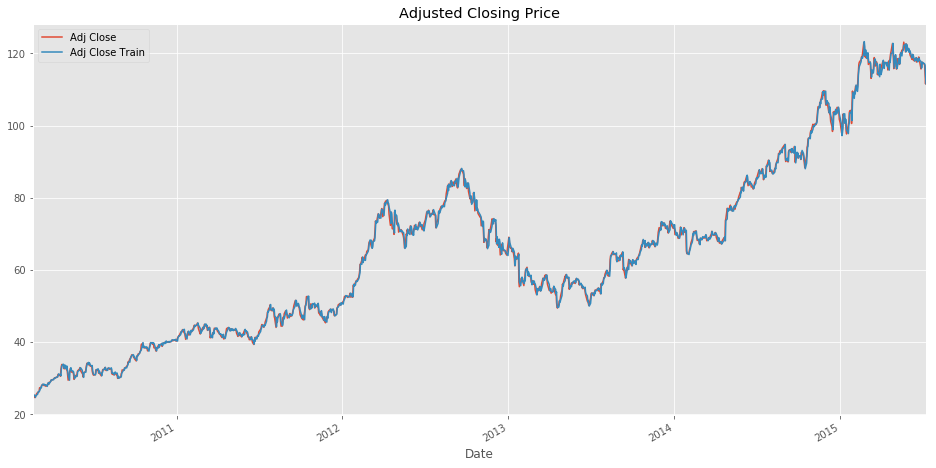

In [16]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

PLOT OF THE TEST DATA AGAINST THE ACTUAL DATA

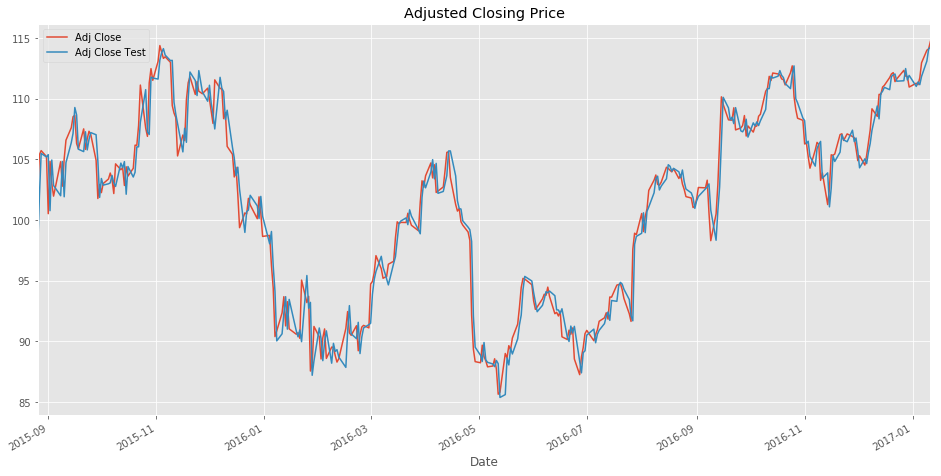

In [17]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

**METHOD 2**. *GRADIENT BOOSTING TREES*

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

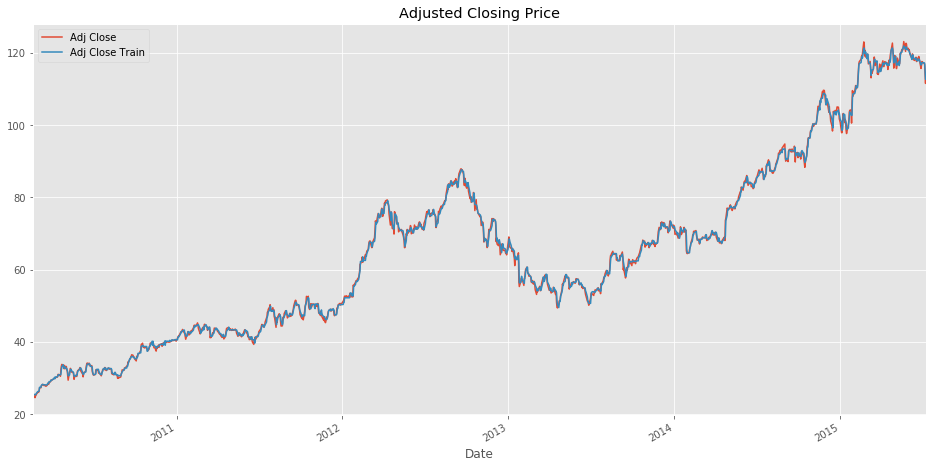

In [19]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

CHECKING THE RESULT OF METHOD 2 AGAINST TEST DATA

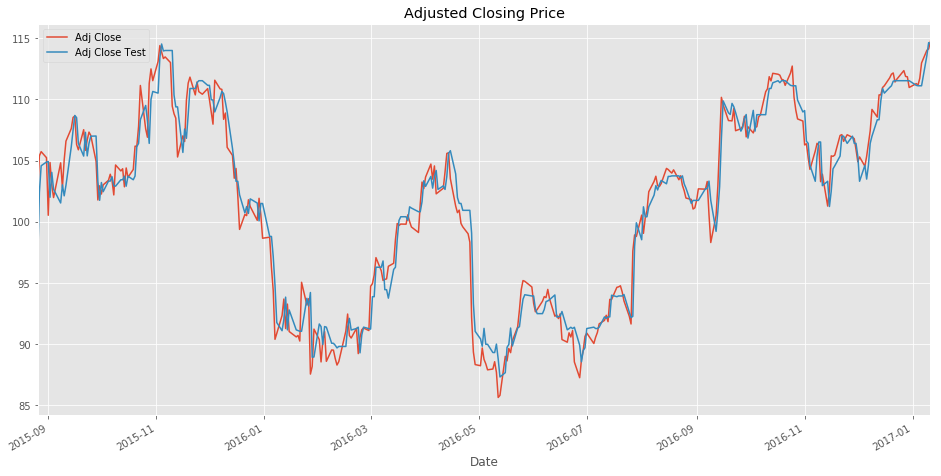

In [20]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

*METHOD 3*. *USING NEURAL NETWORK WITH 1d CONVOLUTION AND LSTM LAYERS*

In [21]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

We need an optimum learning rate for the model to train with. this can be determine
the data for train also needs to be scaled for better output (feature engineering)

In [22]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

Determinging the optimal learning rate

In [23]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1389 samples, validate on 348 samples
Epoch 1/250
1389/1389 [==============================] - 6s 4ms/step - loss: 0.1374 - mean_absolute_error: 0.4400 - val_loss: 0.1619 - val_mean_absolute_error: 0.5481
Epoch 2/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.1374 - mean_absolute_error: 0.4400 - val_loss: 0.1619 - val_mean_absolute_error: 0.5481
Epoch 3/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.1374 - mean_absolute_error: 0.4400 - val_loss: 0.1619 - val_mean_absolute_error: 0.5481
Epoch 4/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.1374 - mean_absolute_error: 0.4400 - val_loss: 0.1619 - val_mean_absolute_error: 0.5481
Epoch 5/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.1374 - mean_absolute_error: 0.4400 - val_loss: 0.1619 - val_mean_absolute_error: 0.5481
Epoch 6/250
1389/1389 

Let's plot the loss for the testing data versus the learning rate.  We can see that it explodes past a learning rate of 1, so let's focus our window to before this point.

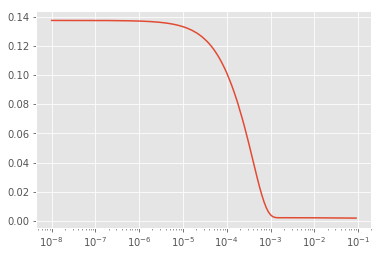

In [26]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

It looks like the learning rate of 0.1 seems to work the best.  Let's use that learning rate and train the network this time for real.  Once we train the network, let's predict the prices for the training and test data.

In [27]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 1389 samples, validate on 348 samples
Epoch 1/250
1389/1389 [==============================] - 5s 4ms/step - loss: 0.0631 - mean_absolute_error: 0.2761 - val_loss: 0.0209 - val_mean_absolute_error: 0.1841
Epoch 2/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.1612 - val_loss: 0.0525 - val_mean_absolute_error: 0.3119
Epoch 3/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.0114 - mean_absolute_error: 0.1151 - val_loss: 0.0196 - val_mean_absolute_error: 0.1792
Epoch 4/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0946 - val_loss: 0.0180 - val_mean_absolute_error: 0.1685
Epoch 5/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.0053 - mean_absolute_error: 0.0818 - val_loss: 0.0037 - val_mean_absolute_error: 0.0679
Epoch 6/250
1389/1389 [==============================] - 3s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0657 - va

NOw we can predict the values but we should rememeber that the original values for the training was normalized. 
During prediction we need to reverse the normalization so that it can be compared to the original data.
it is either the original data is normalized in the same mannaer or the prediction normalization reversed

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

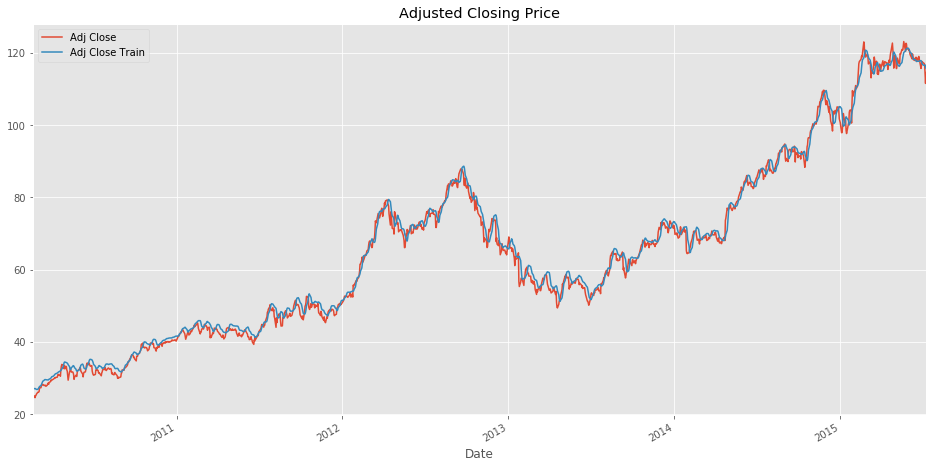

In [29]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

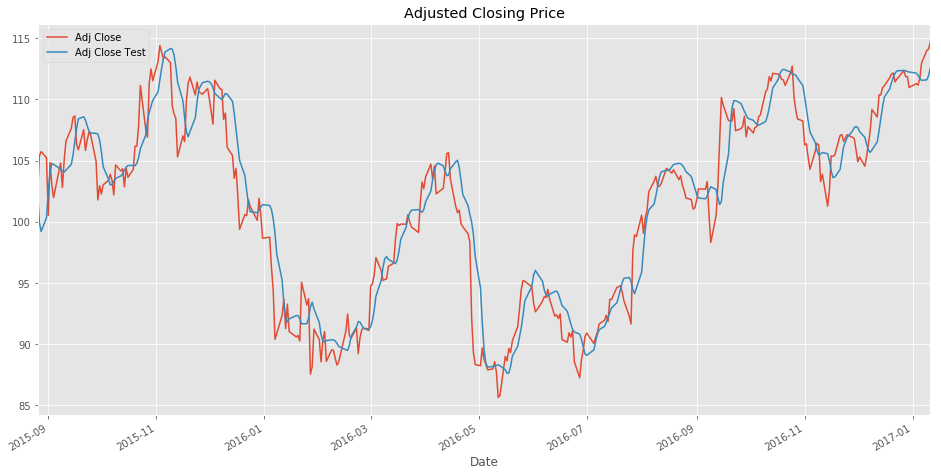

In [30]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)